#1. Problem Tanımı:
Hedef: Spam ve normal (ham) e-postaları ayırt etmek.

Giriş Verisi: "Message" sütunundaki e-posta içerikleri.

Çıkış Verisi: "Category" sütunundaki "spam" veya "ham" etiketi.


#2. Bağımlılıkların Eklenmesi:
Bu aşamada kullanılacak kütüphaneler eklenir.

In [ ]:
import numpy as np #diziler oluşturmak için
import pandas as pd #dataframe oluşturmak için
from sklearn.model_selection import train_test_split #makine öğrenimi için
from sklearn.feature_extraction.text import TfidfVectorizer #metin verilerini sayısal anlamlı değerlere dönüştürmek için çünkü makineyi metin verileri ile beslersek makine bunu anlayamaz.bunun için metni özellik vektörüne dönüştüreceğiz
from sklearn.linear_model import LogisticRegression #postayı spam yada normal olarak sınıflandırmak için kullanılacak olan model
from sklearn.metrics import accuracy_score #doğruluk puanı modelin ne kadar iyi performans gösterdiği için gerekli.
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.stem import PorterStemmer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix







[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#3. Veri Keşfi(Data Exploration):
Veri keşfi aşamasında, veri seti incelenerek verilerin genel yapısını anlamaya çalışılır.

Bu aşamada yapılabilecek işlemler şunlardır;
1. Veri setinizi yüklemek
2. Veri setinin ilk birkaç satırını gözden geçirmek
3. Kategorilerin dağılımını incelemek
4. Eksik veri veya aykırı değerleri kontrol etmek

#### 3.1 Veri setinin yüklenmesi

In [ ]:
# Bu kod veri setini yükler ve bir dataframe oluşturur.
# Bu veri seti "Message" ve "Category" olmak üzere 2 sütun içermektedir.
# "Message" sütununda e-posta mesajlarını "Category" sütununda ise "ham" (normal) veya "spam" değerlerini içerir.
dataframe = pd.read_csv('/content/mail_data.csv')
print(dataframe)

     Category                                            Message
0         ham  Go until jurong point, crazy.. Available only ...
1         ham                      Ok lar... Joking wif u oni...
2        spam  Free entry in 2 a wkly comp to win FA Cup fina...
3         ham  U dun say so early hor... U c already then say...
4         ham  Nah I don't think he goes to usf, he lives aro...
...       ...                                                ...
5567     spam  This is the 2nd time we have tried 2 contact u...
5568      ham               Will ü b going to esplanade fr home?
5569      ham  Pity, * was in mood for that. So...any other s...
5570      ham  The guy did some bitching but I acted like i'd...
5571      ham                         Rofl. Its true to its name

[5572 rows x 2 columns]


#### 3.2 Veri setinin ilk birkaç satırının incelenmesi

In [ ]:
# Bu kod verisetinin ilk 10 satırını görüntüler
print(dataframe.head(10))

  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
5     spam  FreeMsg Hey there darling it's been 3 week's n...
6      ham  Even my brother is not like to speak with me. ...
7      ham  As per your request 'Melle Melle (Oru Minnamin...
8     spam  WINNER!! As a valued network customer you have...
9     spam  Had your mobile 11 months or more? U R entitle...


#### 3.3 Kategorilerin dağılımının incelenmesi

In [ ]:
# Bu kod kategorilerin dağılımını verir.
# Buna göre 4875 adet ham ve 747 adet spam mailimiz mevcut.
kategori_sayisi = dataframe['Category'].value_counts()
print(kategori_sayisi)

ham     4825
spam     747
Name: Category, dtype: int64


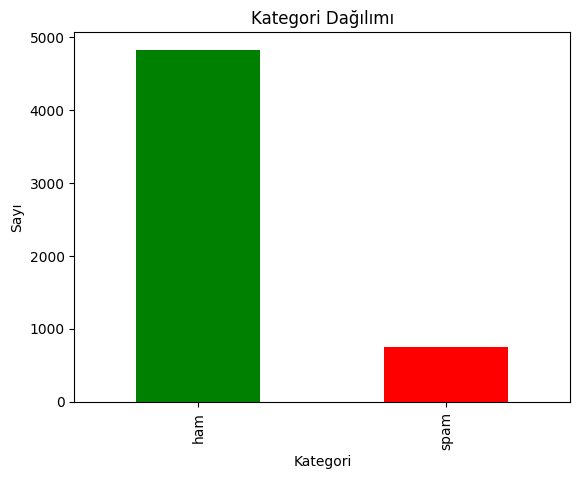

In [ ]:
# Bu kod kategorilerimizin dağılımını çubuk grafiği ile görselleştirir.
# Görsele baktığımızda kategorilerimizin dengeli dağılmadığını anlıyoruz.
# Çünkü ham maillerin sayısı spam maillerden kat kat fazla.
dataframe['Category'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Kategori Dağılımı')
plt.xlabel('Kategori')
plt.ylabel('Sayı')
plt.show()

#### 3.4 Eksik değerlerin incelenmesi

In [ ]:
# Bu kod veri setindeki eksik (NULL veya NaN) değerlerin sayısını gösterir.
# Bu Verisetinde eksik değer bulunmamaktadır.
missing_values = dataframe.isnull().sum()
print(missing_values)

Category    0
Message     0
dtype: int64


#4. Veri Ön İşleme(Data Preprocessing):
Veri ön işleme, veri setini temizleme ve modele uygun hale getirme sürecidir.

1. [0-9] gibi sayısal ifadelerin kaldırılması
2. "#", "%", "&" gibi özel karakterlerin kaldırılması
3. Büyük harflerin küçük harfe dönüştürülmesi
4. Etkisiz kelimelerin (Stopwords) çıkarılması
5. Kelime köklerinin bulunması
6. Label Encoding

#### 4.1 Sayısal İfadelerin Kaldırılması

In [ ]:
# 'Message' sütununa uygulanacak fonksiyon
def remove_numbers(text):
    return re.sub(r'[0-9]', '', text)

# 'Message' sütununa uygula
dataframe['Message'] = dataframe['Message'].apply(remove_numbers)


#### 4.2 Özel Karakterlerin Kaldırılması

In [ ]:
# 'Message' sütununa uygulanacak fonksiyon
def remove_special_characters(text):
    return re.sub(r'[^\w\s]', '', text)

# 'Message' sütununa uygula
dataframe['Message'] = dataframe['Message'].apply(remove_special_characters)

#### 4.3 Büyük Harflerin Küçük Harflere Dönüştürülmesi

In [ ]:
# 'Message' sütununa uygulanacak fonksiyon
def convert_to_lowercase(text):
    return text.lower()

# 'Message' sütununa uygula
dataframe['Message'] = dataframe['Message'].apply(convert_to_lowercase)

#### 4.4 Etkisiz Kelimelerin (stopwords) Kaldırılması

In [ ]:
# Stopword listesini yükle
stop_words = set(stopwords.words('english'))

# Metin verilerinden stopword'leri çıkar
def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# "Message" sütunundaki metin verilerine stopword temizleme işlemini uygula
dataframe['Message'] = dataframe['Message'].apply(remove_stopwords)

#### 4.5 Kelimelerin Köklerinin Çıkarılması

In [ ]:
# Porter Stemmer'ı yükle
stemmer = PorterStemmer()

# Metin verilerinde stemming işlemini uygula
def stem_text(text):
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

# "Message" sütunundaki metin verilerine stemming işlemini uygula
dataframe['Message'] = dataframe['Message'].apply(stem_text)

#### 4.6 Label Encoding
 Veri setindeki kategorik sütunları ("ham" ve "spam" gibi) sayısal değerlere dönüştürmek için kullanılır.

In [ ]:
# kategori sütununda "spam" değerlerini "0" ve "ham" değerlerini "1" olarak sayısal değerlere dönüştürür.
dataframe.loc[dataframe['Category'] == 'spam', 'Category',] = 0
dataframe.loc[dataframe['Category'] == 'ham', 'Category',] = 1

#5. Veri Setinin X ve Y ye bölünmesi

In [ ]:
# Bağımsız değişken (X) ve bağımlı değişken (Y) ayırma
X = dataframe['Message']
Y = dataframe['Category']

#6. Özellik Çıkarımı (Feature Extraction)
Spam mail analizi için özellik çıkarımı, metin verilerini anlamlı sayısal özelliklere dönüştürme sürecidir. Bu özellikler, metin verilerinin içerdiği bilgileri daha iyi temsil edebilecek formatta olmalıdır.

#### 6.1 TF-IDF Yöntemi

In [ ]:
# TF-IDF vektörleme
vectorizer = TfidfVectorizer(min_df=1, stop_words='english', lowercase=True)
X_tfidf = vectorizer.fit_transform(X)
print(X_tfidf)

  (0, 6574)	0.19702290780713422
  (0, 204)	0.3546607748984538
  (0, 2362)	0.1644114271559457
  (0, 1043)	0.2996188558139331
  (0, 773)	0.33856204558236747
  (0, 3215)	0.290759085739021
  (0, 6771)	0.24101894405056848
  (0, 2398)	0.19739925519222162
  (0, 775)	0.2996188558139331
  (0, 391)	0.2696908349561709
  (0, 1257)	0.27466035642293457
  (0, 4537)	0.24216987541391052
  (0, 3077)	0.3546607748984538
  (1, 4193)	0.5633498837724461
  (1, 6683)	0.44483654514496557
  (1, 3043)	0.4773478663822099
  (1, 3247)	0.42081977871680865
  (1, 4164)	0.2825014776211812
  (2, 275)	0.18755840752900615
  (2, 4828)	0.2634654233065953
  (2, 6282)	0.13946211747839518
  (2, 4781)	0.2634654233065953
  (2, 4868)	0.1811980918209888
  (2, 5965)	0.1327917042898782
  (2, 5618)	0.17592618836413482
  :	:
  (5567, 6227)	0.2714951974121916
  (5567, 6081)	0.2336687692698023
  (5567, 4588)	0.3462412984367328
  (5567, 1050)	0.27498853753751695
  (5567, 4673)	0.288309763413607
  (5568, 1825)	0.6932133474261023
  (5568, 2

In [ ]:
    #veriler object tipindedir. tamsayıya dönüştürmek makinenin daha kolay anlamasını sağlamaktadır.
    Y = Y.astype('int')


#EĞİTİM VE TEST KÜMELERİNİN OLUŞTURULMASI

In [ ]:
# Veriyi eğitim ve test kümelerine bölelim
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y, test_size=0.2, random_state=42)

#KNN İÇİN EN İYİ K DEĞERİNİN HESAPLANMASI


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# K değerlerini belirleyin
k_values = list(range(1, 21))

# Her k değeri için modeli eğit ve test et
for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'K={k}, Doğruluk: {accuracy}')



K=1, Doğruluk: 0.9533632286995516
K=2, Doğruluk: 0.9515695067264573
K=3, Doğruluk: 0.9345291479820628
K=4, Doğruluk: 0.9345291479820628
K=5, Doğruluk: 0.9210762331838565
K=6, Doğruluk: 0.9210762331838565
K=7, Doğruluk: 0.9094170403587444
K=8, Doğruluk: 0.9094170403587444
K=9, Doğruluk: 0.9022421524663677
K=10, Doğruluk: 0.9022421524663677
K=11, Doğruluk: 0.8896860986547085
K=12, Doğruluk: 0.8896860986547085
K=13, Doğruluk: 0.884304932735426
K=14, Doğruluk: 0.884304932735426
K=15, Doğruluk: 0.8780269058295964
K=16, Doğruluk: 0.8780269058295964
K=17, Doğruluk: 0.8762331838565023
K=18, Doğruluk: 0.8762331838565023
K=19, Doğruluk: 0.8762331838565023
K=20, Doğruluk: 0.8762331838565023


#EN İYİ K DEĞERİ İÇİN MODELİN KNN İLE EĞİTİM VE TEST AŞAMASI


Cross-Validation Aşaması 1:
Accuracy: 0.9506726457399103
Precision: 0.9469548133595285
Recall: 0.9989637305699481
F1-score: 0.9722642460917801

Cross-Validation Aşaması 2:
Accuracy: 0.9443946188340807
Precision: 0.9404878048780487
Recall: 0.9989637305699481
F1-score: 0.9688442211055276

Cross-Validation Aşaması 3:
Accuracy: 0.9443447037701975
Precision: 0.9404878048780487
Recall: 0.9989637305699481
F1-score: 0.9688442211055276

Cross-Validation Aşaması 4:
Accuracy: 0.9488330341113106
Precision: 0.9459724950884086
Recall: 0.9979274611398964
F1-score: 0.9712556732223903

Cross-Validation Aşaması 5:
Accuracy: 0.9443447037701975
Precision: 0.9404878048780487
Recall: 0.9989637305699481
F1-score: 0.9688442211055276

Ortalama Skorlar:
Ortalama Accuracy: 0.9465179412451393
Ortalama Precision: 0.9428781446164166
Ortalama Recall: 0.9987564766839376
Ortalama F1-score: 0.9700105165261507
KNN MODELİ İÇİN:
Accuracy: 0.9533632286995516
Precision: 0.9498031496062992
Recall: 0.9989648033126294
F1-scor

Text(45.72222222222221, 0.5, 'Gerçek Sınıflar')

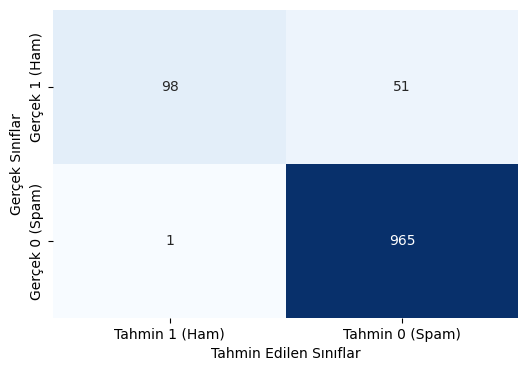

In [ ]:

# k-NN modelini oluşturun ve 5 parça cross-validation kullanarak eğitin
knn_model = KNeighborsClassifier(n_neighbors=1,metric='euclidean')  # k=1 olarak belirlendi.

from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# k-NN modelini oluşturun ve 1 parça cross-validation kullanarak eğitin
knn_model = KNeighborsClassifier(n_neighbors=1, metric='euclidean')  # k=1 olarak belirlendi.

# Cross-validation metriklerini belirtin
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Cross-validation skorlarını hesapla
cv_results = cross_validate(knn_model, X_tfidf, Y, cv=5, scoring=scoring)

# Her cross-validation aşamasında elde edilen skorları ekrana yazdır
for i in range(5):
    print(f"\nCross-Validation Aşaması {i + 1}:")
    print(f"Accuracy: {cv_results['test_accuracy'][i]}")
    print(f"Precision: {cv_results['test_precision'][i]}")
    print(f"Recall: {cv_results['test_recall'][i]}")
    print(f"F1-score: {cv_results['test_f1'][i]}")

# Ortalama skorları ekrana yazdır
print("\nOrtalama Skorlar:")
print(f"Ortalama Accuracy: {cv_results['test_accuracy'].mean()}")
print(f"Ortalama Precision: {cv_results['test_precision'].mean()}")
print(f"Ortalama Recall: {cv_results['test_recall'].mean()}")
print(f"Ortalama F1-score: {cv_results['test_f1'].mean()}")


# Modeli eğitin
knn_model.fit(X_train, y_train)

# Test kümesi üzerinde tahmin yapın
y_pred = knn_model.predict(X_test)

# Modelin performansını değerlendirin
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)

#confusion matrix
cm = confusion_matrix(y_test,y_pred)

print("KNN MODELİ İÇİN:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1score}")
print(cm)

# Confusion matrix çizimi
# Heatmap çizimi
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Tahmin 1 (Ham)", "Tahmin 0 (Spam)"],
            yticklabels=["Gerçek 1 (Ham)", "Gerçek 0 (Spam)"])
plt.xlabel("Tahmin Edilen Sınıflar")
plt.ylabel("Gerçek Sınıflar")


#MODELİN LOJİSTİK REGRESYON İLE EĞİTİM VE TEST AŞAMASI


Cross-Validation Aşaması 1:
Accuracy: 0.9623318385650225
Precision: 0.9592039800995025
Recall: 0.9989637305699481
F1-score: 0.9786802030456851

Cross-Validation Aşaması 2:
Accuracy: 0.9497757847533632
Precision: 0.9460255152109912
Recall: 0.9989637305699481
F1-score: 0.9717741935483871

Cross-Validation Aşaması 3:
Accuracy: 0.9533213644524237
Precision: 0.9488692232055064
Recall: 1.0
F1-score: 0.9737638748738648

Cross-Validation Aşaması 4:
Accuracy: 0.9515260323159784
Precision: 0.9478859390363815
Recall: 0.9989637305699481
F1-score: 0.9727547931382441

Cross-Validation Aşaması 5:
Accuracy: 0.9569120287253142
Precision: 0.9544103072348861
Recall: 0.9979274611398964
F1-score: 0.9756838905775076

Ortalama Skorlar:
Ortalama Accuracy: 0.9547734097624204
Ortalama Precision: 0.9512789929574534
Ortalama Recall: 0.9989637305699481
Ortalama F1-score: 0.9745313910367377
Logistic Regression Modeli ile:
Accuracy: 0.9551569506726457
Precision: 0.9507874015748031
Recall: 1.0
F1-score: 0.9747729566

Text(45.72222222222221, 0.5, 'Gerçek Sınıflar')

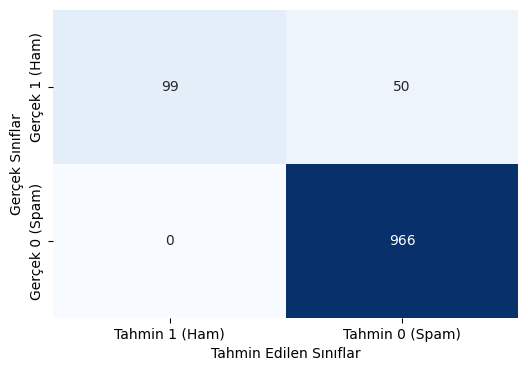

In [ ]:
# Logistic Regression modelini oluşturun
lr_model = LogisticRegression()

# Cross-validation metriklerini belirtin
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Cross-validation skorlarını hesapla
cv_results = cross_validate(lr_model, X_tfidf, Y, cv=5, scoring=scoring)

# Her cross-validation aşamasında elde edilen skorları ekrana yazdır
for i in range(5):
    print(f"\nCross-Validation Aşaması {i + 1}:")
    print(f"Accuracy: {cv_results['test_accuracy'][i]}")
    print(f"Precision: {cv_results['test_precision'][i]}")
    print(f"Recall: {cv_results['test_recall'][i]}")
    print(f"F1-score: {cv_results['test_f1'][i]}")

# Ortalama skorları ekrana yazdır
print("\nOrtalama Skorlar:")
print(f"Ortalama Accuracy: {cv_results['test_accuracy'].mean()}")
print(f"Ortalama Precision: {cv_results['test_precision'].mean()}")
print(f"Ortalama Recall: {cv_results['test_recall'].mean()}")
print(f"Ortalama F1-score: {cv_results['test_f1'].mean()}")

# Modeli eğitin
lr_model.fit(X_train, y_train)

# Test kümesi üzerinde tahmin yapın
y_pred = lr_model.predict(X_test)

# Modelin performansını değerlendirin
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)

#confusion matrix
cm = confusion_matrix(y_test, y_pred)


print("Logistic Regression Modeli ile:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1score}")
print(cm)

# Confusion matrix çizimi
# Heatmap çizimi
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Tahmin 1 (Ham)", "Tahmin 0 (Spam)"],
            yticklabels=["Gerçek 1 (Ham)", "Gerçek 0 (Spam)"])
plt.xlabel("Tahmin Edilen Sınıflar")
plt.ylabel("Gerçek Sınıflar")



#YENİ ÖRNEKLERLE TAHMİN

In [ ]:
#rastgele bir mail örneğinden tahmin etmesini isteyelim.
input_mail = ["You've Won a Prize! Hello, You have won the first prize! Click now to claim your new MacBook Pro and $10,000 in cash. All you need to do is share your personal information and credit card details. Don't miss your chance! Best regards, Apple Company"]

#mailin tfidf vektörüne dönüşümü
input_data_tfidf = vectorizer.transform(input_mail)

#tahmin edilmesi
prediction = knn_model.predict(input_data_tfidf)
print(prediction)

#mail ham yani 1 olarak sonuç vermelidir. BU NEDENLE İF KOŞULU YAZILDI.
if prediction[0]==1:
  print('not-spam mail')
else:
  print('spam mail')

[1]
not-spam mail
